In [9]:
import seaborn as sns 
import scanpy as sc
import pandas as pd
import anndata
import numpy as np   
# import episcanpy.api as epi
# import scvi
import matplotlib.pyplot as plt
import scipy
import h5py    
import scipy.sparse as sparse
import scipy.io as sio
import scipy.stats as stats

from typing import Dict, Iterable, Optional

import numpy as np
import torch
from torch.distributions import Normal, Poisson
from torch.distributions import kl_divergence as kld
from torch import tensor
from complementary_models import HALOVIR as HALOVI
from complementary_models import HALOVAER as HALOVAE
import scanpy as sc
import scvi
import pandas as pd

In [10]:
adata_multi = sc.read_h5ad("openproblem/neurips_traj.h5ad")
adata_multi.X = adata_multi.layers['counts']
newadata = adata_multi[adata_multi.obs['GEX_pseudotime_order'].notna()].copy()
adata_mvi = scvi.data.organize_multiome_anndatas(newadata)

adata_mvi 

AnnData object with n_obs × n_vars = 10862 × 129921
    obs: 'GEX_pct_counts_mt', 'GEX_n_counts', 'GEX_n_genes', 'GEX_size_factors', 'GEX_phase', 'ATAC_nCount_peaks', 'ATAC_atac_fragments', 'ATAC_reads_in_peaks_frac', 'ATAC_blacklist_fraction', 'ATAC_nucleosome_signal', 'cell_type', 'batch', 'ATAC_pseudotime_order', 'GEX_pseudotime_order', 'Samplename', 'Site', 'DonorNumber', 'Modality', 'VendorLot', 'DonorID', 'DonorAge', 'DonorBMI', 'DonorBloodType', 'DonorRace', 'Ethnicity', 'DonorGender', 'QCMeds', 'DonorSmoker', 'modality'
    var: 'feature_types', 'gene_id'
    uns: 'ATAC_gene_activity_var_names', 'dataset_id', 'genome', 'organism'
    obsm: 'ATAC_gene_activity', 'ATAC_lsi_full', 'ATAC_lsi_red', 'ATAC_umap', 'GEX_X_pca', 'GEX_X_umap'
    layers: 'counts'

In [11]:
HALOVI.setup_anndata(adata_mvi, batch_key="batch", time_key='GEX_pseudotime_order')
model = HALOVI(
    adata_mvi,
    n_genes=(adata_mvi.var['feature_types']=='GEX').sum(),
    n_regions=(adata_mvi.var['feature_types']=='ATAC').sum()
)

n_genes :13431


In [12]:
## train both RNA and ATAC
# import warnings
# warnings.filterwarnings("ignore")
model.module.set_train_params(expr_train=True, acc_train=True)
model.module.set_finetune_params(0)
model.train(max_epochs=10)

/home/haiyi/anaconda3/envs/halo/lib/python3.9/site-packages/scvi/model/base/_training_mixin.py:67: UserWarning: max_epochs=10 is less than n_epochs_kl_warmup=400. The max_kl_weight will not be reached during training.
  warnings.warn(
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 10/10: 100%|██████████| 10/10 [01:12<00:00,  7.20s/it, loss=4.68e+04, v_num=1]


In [13]:
model.module.set_train_params(expr_train=True, acc_train=False)
model.module.set_finetune_params(0)
model.train(max_epochs=2)

/home/haiyi/anaconda3/envs/halo/lib/python3.9/site-packages/scvi/model/base/_training_mixin.py:67: UserWarning: max_epochs=2 is less than n_epochs_kl_warmup=400. The max_kl_weight will not be reached during training.
  warnings.warn(
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 2/2: 100%|██████████| 2/2 [00:13<00:00,  6.73s/it, loss=4.15e+03, v_num=1]


In [14]:
model.module.set_train_params(expr_train=False, acc_train=True)
model.module.set_finetune_params(0)
model.train(max_epochs=2)

/home/haiyi/anaconda3/envs/halo/lib/python3.9/site-packages/scvi/model/base/_training_mixin.py:67: UserWarning: max_epochs=2 is less than n_epochs_kl_warmup=400. The max_kl_weight will not be reached during training.
  warnings.warn(
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 2/2: 100%|██████████| 2/2 [00:13<00:00,  6.78s/it, loss=1.16e+04, v_num=1]


In [15]:
model.module.set_train_params(expr_train=True, acc_train=True)
model.module.set_finetune_params(2)
model.module.set_scale_params(1e6,1e8,5e5)
model.train(max_epochs=10)

/home/haiyi/anaconda3/envs/halo/lib/python3.9/site-packages/scvi/model/base/_training_mixin.py:67: UserWarning: max_epochs=10 is less than n_epochs_kl_warmup=400. The max_kl_weight will not be reached during training.
  warnings.warn(
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 10/10: 100%|██████████| 10/10 [01:39<00:00,  9.90s/it, loss=1.43e+05, v_num=1]


In [29]:
model.save("neurips2", overwrite=True)

In [8]:
model.load("neurips1", adata_mvi)

INFO     File neurips1/model.pt already downloaded                                           


ValueError: Save path contains no saved anndata and no adata was passed.

In [16]:
import matplotlib.pyplot as plt


latent_expr, latent_acc,latent_atac_dep, latent_expr_dep, latent_atac_indep, latent_expr_indep, times  = model.get_latent_representation()


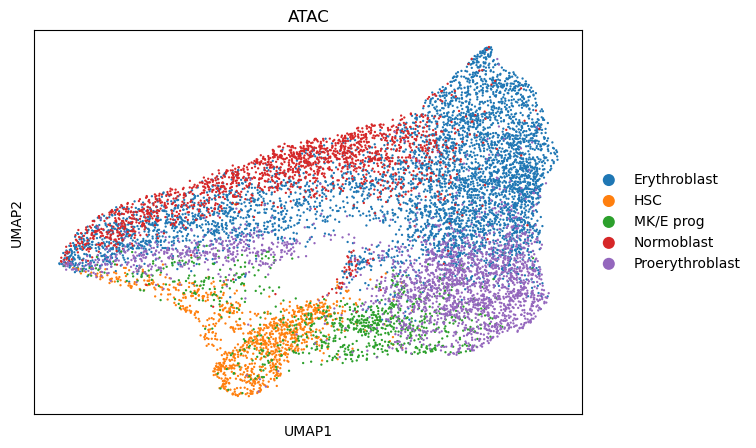

In [17]:
adata_mvi.obsm["latent"] = latent_acc
sc.pp.neighbors(adata_mvi, use_rep="latent", n_neighbors=25)

sc.tl.umap(adata_mvi,min_dist =0.5)
# sc.tl.louvain(adata_mvi)

%matplotlib inline
# sc.pl.umap(adata_mvi, color=['celltype'])
sc.pl.scatter(adata_mvi,color='cell_type',basis='umap',
             title = 'ATAC')
plt.show()

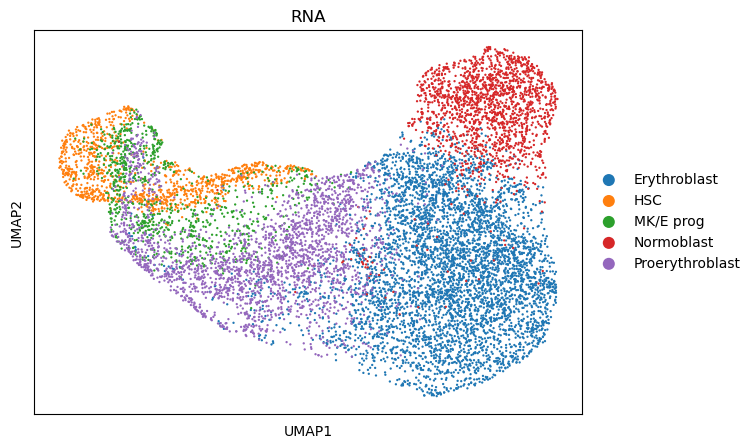

In [19]:
adata_mvi.obsm["latent"] = latent_expr
sc.pp.neighbors(adata_mvi, use_rep="latent", n_neighbors=25)

sc.tl.umap(adata_mvi,min_dist =0.5)
# sc.tl.louvain(adata_mvi)

%matplotlib inline
# sc.pl.umap(adata_mvi, color=['celltype'])
sc.pl.scatter(adata_mvi,color='cell_type',basis='umap',
             title = 'RNA')
plt.show()

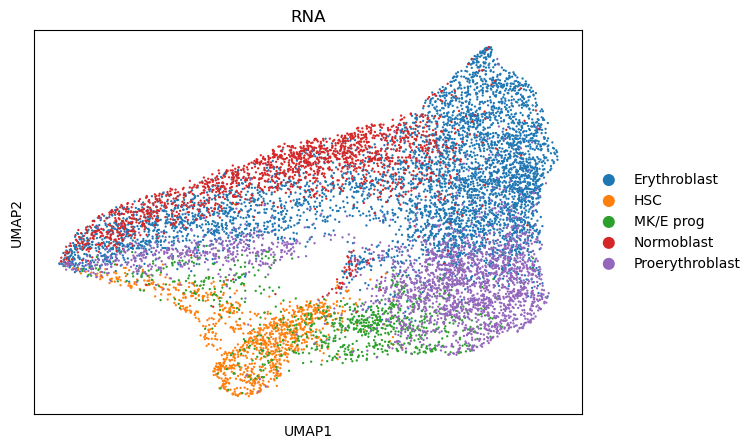

In [18]:
adata_mvi.obsm["latent"] = np.concatenate([latent_expr, latent_acc], axis=1)

sc.tl.umap(adata_mvi,min_dist =0.5)
# sc.tl.louvain(adata_mvi)

%matplotlib inline
# sc.pl.umap(adata_mvi, color=['celltype'])
sc.pl.scatter(adata_mvi,color='cell_type',basis='umap',
             title = 'RNA')
plt.show()

In [20]:
# from complementary_models import torch_infer_nonsta_dir
from complementary_models.infer_nonsta_dir import infer_nonsta_dir

# latent_atac_indep = torch.tensor(latent_atac_indep).to('cuda')
# latent_expr_indep = torch.tensor(latent_expr_indep).to('cuda')
# times = torch.tensor(times).to('cuda')

score3, _, _ = infer_nonsta_dir(latent_atac_indep, latent_expr_indep, times)
score4, _, _ = infer_nonsta_dir(latent_expr_indep, latent_atac_indep, times)
score3 - score4

0.01239624333235112

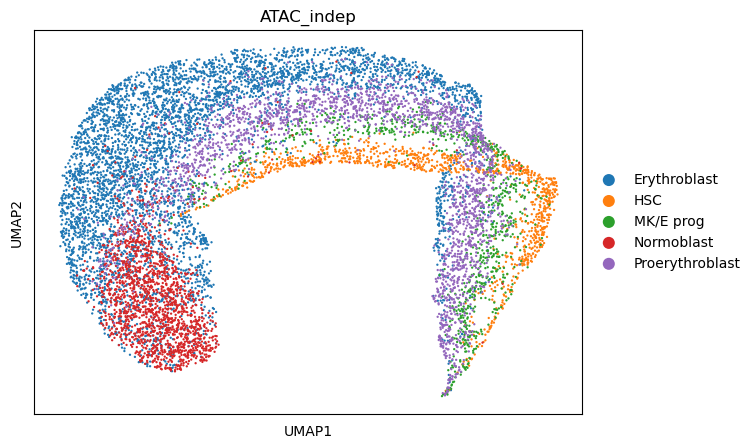

In [20]:
adata_mvi.obsm["latent"] = latent_atac_indep.detach().cpu().numpy()
sc.pp.neighbors(adata_mvi, use_rep="latent", n_neighbors=25)

sc.tl.umap(adata_mvi,min_dist =0.5)
# sc.tl.louvain(adata_mvi)

%matplotlib inline
# sc.pl.umap(adata_mvi, color=['celltype'])
sc.pl.scatter(adata_mvi,color='cell_type',basis='umap',
             title = 'ATAC_indep')
plt.show()

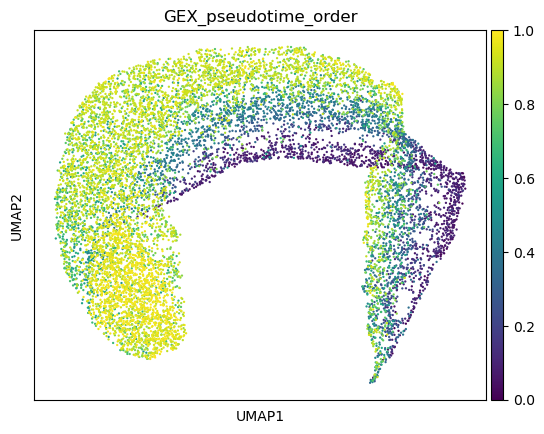

In [21]:
sc.pl.umap(adata_mvi, color=['GEX_pseudotime_order'])

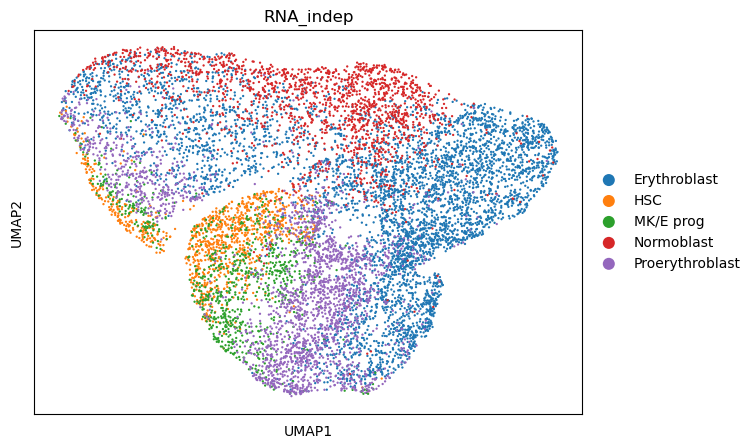

In [23]:
adata_mvi.obsm["latent"] = latent_expr_indep.detach().cpu().numpy()
sc.pp.neighbors(adata_mvi, use_rep="latent", n_neighbors=30)

sc.tl.umap(adata_mvi,min_dist =0.5)
# sc.tl.louvain(adata_mvi)

%matplotlib inline
# sc.pl.umap(adata_mvi, color=['celltype'])
sc.pl.scatter(adata_mvi,color='cell_type',basis='umap',
             title = 'RNA_indep')
plt.show()

In [ ]:
sc.pl.umap(adata_mvi, color=['GEX_pseudotime_order'])

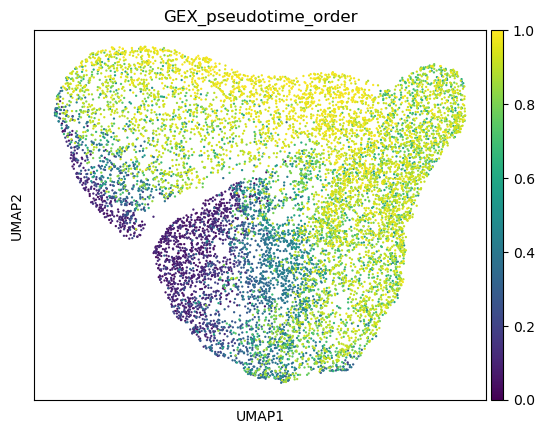

In [19]:
sc.pl.umap(adata_mvi, color=['GEX_pseudotime_order'])

In [ ]:
import sklearn.linear_model.Lasso as lasso